# CSCA 5642: Introduction to Deep Learning: Week 3 Mini-Project 

## Brief Description of the Problem and Data
The Histopathological Cancer Detection Kraggle competition challenges participants to develop a binary image classifcation model to identify metastatic cancer in small image patches extracted from larger digital pathology scans. The objective is to classify all image patches as either (1) containing cancerous tissue, or (0), not containing cancerous tissue, making it a critical task for advanced diagnostic tools.

The dataset provided for this competition is substantial in size, consisting of:
- Training set: 220,025 images
- Test set: 57,468 images

Each image is a color image in RGB with dimensions of 96x96 pixels and is tored in TIFF format. The training labels are provided in a CSV file, mapping each image ID to its corresponding binary label (0 or 1). The images were derived from digital pathology scans, with patches specifically extracted to focus on regions relevant for cancer detection.

A notable characteristic of this type of data is the class imbalance: there is higher proportion of non-cancerous classes than cancerous classes. This imbalance is critical to consider for this study and will influence the model training and evaluation strategies, as it may require advanced techniques.

## Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data
In this step, we will explore the dataset by inspecting its structure, visualizing the images and their properties, and cleaning any potential issues. Based on these findings, we will outline a plan for further analysis and model development.

### Inspect the Data
We start by loading the training labels and examining their distribution

First rows of the training labels:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


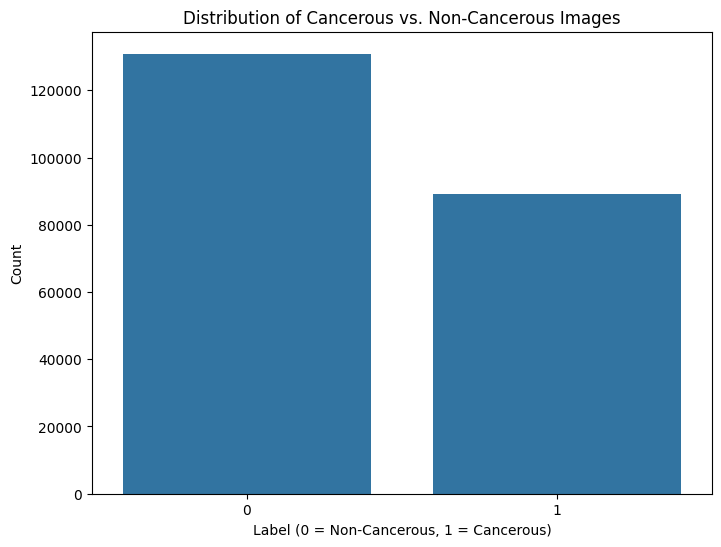

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train_labels = pd.read_csv("data/train_labels.csv")

print("First rows of the training labels:")
print(train_labels.head())

plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=train_labels)
plt.title('Distribution of Cancerous vs. Non-Cancerous Images')
plt.xlabel('Label (0 = Non-Cancerous, 1 = Cancerous)')
plt.ylabel('Count')
plt.show()


As seen in the distribution plot, roughly 60% of the dataset is non-cancerous (label 0) images, and the remaining 40% are cancerous.

### Visualize the Data
We'll display sample images from both classes and plot histograms of pixel intensities to explore color distributions.

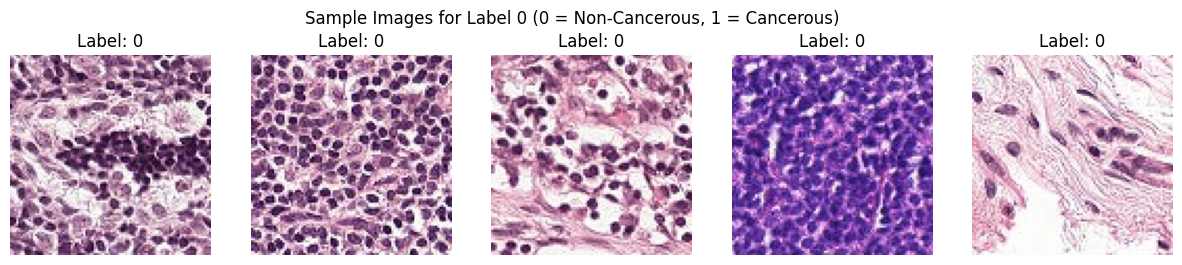

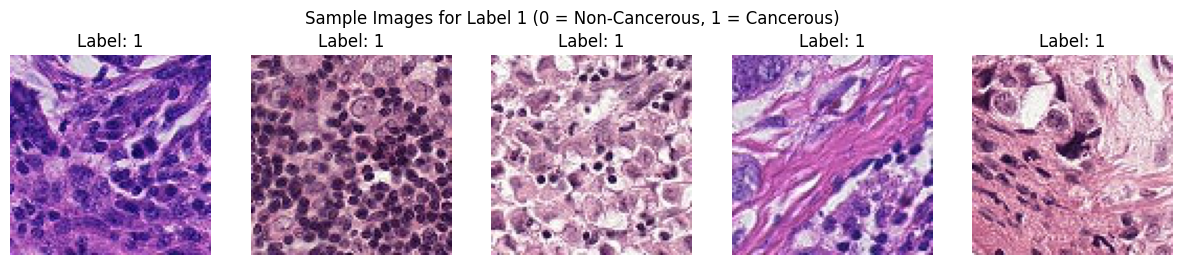

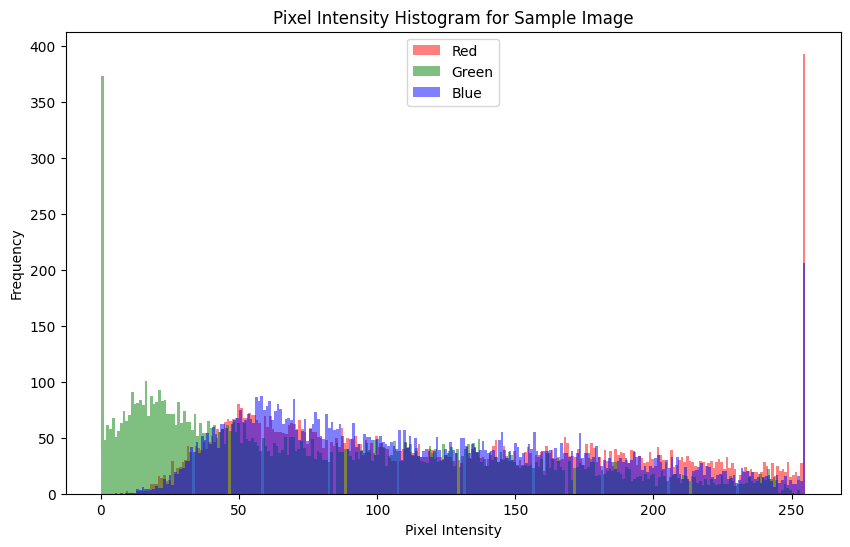

In [2]:
import numpy as np
from PIL import Image

def display_samples(label, n_samples=5):
    samples = train_labels[train_labels['label'] == label].sample(n_samples)
    fig, axes = plt.subplots(1, n_samples, figsize=(15, 3))
    for i, (idx, row) in enumerate(samples.iterrows()):
        img_path = f'data/train/{row["id"]}.tif'
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.suptitle(f'Sample Images for Label {label} (0 = Non-Cancerous, 1 = Cancerous)')
    plt.show()

display_samples(0)
display_samples(1)

def plot_histogram(img_path):
    img = Image.open(img_path)
    img_array = np.array(img)
    plt.figure(figsize=(10, 6))
    plt.hist(img_array[:, :, 0].ravel(), bins=256, color='red', alpha=0.5, label='Red')
    plt.hist(img_array[:, :, 1].ravel(), bins=256, color='green', alpha=0.5, label='Green')
    plt.hist(img_array[:, :, 2].ravel(), bins=256, color='blue', alpha=0.5, label='Blue')
    plt.legend()
    plt.title('Pixel Intensity Histogram for Sample Image')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

sample_img_path = 'data/train/ff692974d748bca155fbb87d8f4e47dc7d44c67b.tif'
plot_histogram(sample_img_path)

Non-cancerous images (label 0) often appear more uniform with lighter, more consistent tissue patterns. Cancerous images (label 1) show denser, irregular structures. The histograms indicate a wide range of colors across the RGB channels and intensities, with a pinkish hue from staining.

### Clean the Data
Given the large size of the training set (220,025 images), we'll check for corrupted or unreadable images and confirm that all images match the 96x96 RGB format.

In [3]:
import os

def check_images(directory):
    corrupted = []
    for root, _, files in os.walk(directory):
        for file in files:
            try:
                img = Image.open(os.path.join(root, file))
                img.verify()
                img = Image.open(os.path.join(root, file))
                if img.size != (96, 96) or img.mode != 'RGB':
                    corrupted.append(file)
            except Exception as e:
                corrupted.append(file)
    return corrupted

train_dir = 'data/train'
corrupted_images = check_images(train_dir)
print(f'Corrupted or incorrectly formatted images: {corrupted_images}')

if corrupted_images:
    train_labels = train_labels[~train_labels['id'].isin([os.path.splitext(img)[0] for img in corrupted_images])]
    print(f"Removed {len(corrupted_images)} corrupted images from the dataset.")
else:
    print("No corrupted images found.")

Corrupted or incorrectly formatted images: []
No corrupted images found.


## Model Architecture
In this step, we design and implement a CNN to classify each image patch as cancerous or non-cancerous. CNNs are particularly suitable for image classification because they learn relevant spatial features (e.g. edges, textures, shapes) through convolution and pooling operations. Below are two approaches:
1. **Custom CNN**: Build a CNN from scratch with several convolutional and pooling layers, followed by fully connected layers.
2. **Transfer Learning**: Leverage a pretrained CNNs and fine-tune the top layers for this classification task.

The from-scratch CNN allows us to have full control over the architecture and start with a fresh plate. However, the transfer learning approach can be beneficial when the new learning task is relatively similar to the data the pretrained model was trained on. Below is an implementatino for both models


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Example 1: Custom CNN
def build_custom_cnn(input_shape=(96, 96, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizers.Adam(learning_rate=0.0001),
        metrics=['accuracy']
    )
    return model

custom_cnn = build_custom_cnn()
print(custom_cnn.summary())

# Example 2: Transfer Learning with ResNet50
def build_resnet50_transfer(input_shape=(96, 96, 3)):
    # Load ResNet50 with pretrained ImageNet weights, excluding the top layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the base_model layers so we only train the top layers
    for layer in base_model.layers:
        layer.trainable = False

    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Lambda(preprocess_input),  # Scale input for ResNet50
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizers.Adam(learning_rate=0.0001),
        metrics=['accuracy']
    )
    return model

resnet50_transfer = build_resnet50_transfer()
print(resnet50_transfer.summary())

/Users/jeffreylind/anaconda3/envs/CSCA/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,731,905 (6.61 MB)

 Trainable params: 1,731,905 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 3, 3, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

None


## Results and Analysis
Now, we will train both models and compare their performances. Below is the implementation for this.

Training samples: 176020, Validation samples: 44005
Found 176020 validated image filenames.
Found 44005 validated image filenames.
Epoch 1/5


/Users/jeffreylind/anaconda3/envs/CSCA/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 378s 69ms/step - accuracy: 0.7644 - loss: 0.4959 - val_accuracy: 0.7521 - val_loss: 0.5556
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 360s 65ms/step - accuracy: 0.8280 - loss: 0.3961 - val_accuracy: 0.7940 - val_loss: 0.4622
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 363s 66ms/step - accuracy: 0.8490 - loss: 0.3527 - val_accuracy: 0.8085 - val_loss: 0.4440
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 365s 66ms/step - accuracy: 0.8609 - loss: 0.3269 - val_accuracy: 0.8435 - val_loss: 0.3838
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 392s 71ms/step - accuracy: 0.8752 - loss: 0.2994 - val_accuracy: 0.8574 - val_loss: 0.3597
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step - accuracy: 0.8560 - loss: 0.3582
Custom CNN Validation Loss: 0.3597, Accuracy: 0.8574
Epoch 1/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 992s 180ms/step - accuracy: 0.5696 - loss: 0.6934 - val_accuracy: 0.5956 - val_loss: 0.6592
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 985s 179ms/step - accuracy: 0.5954 - loss: 0

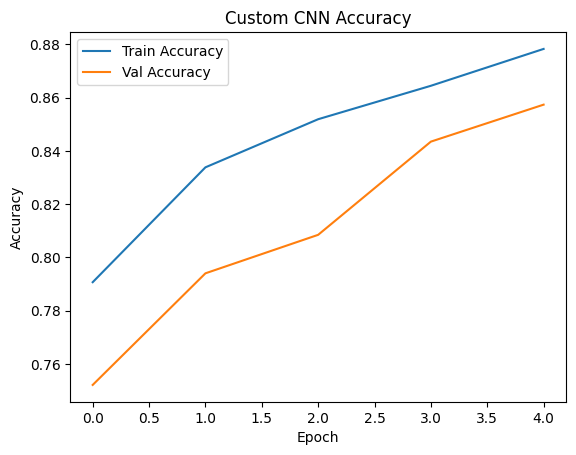

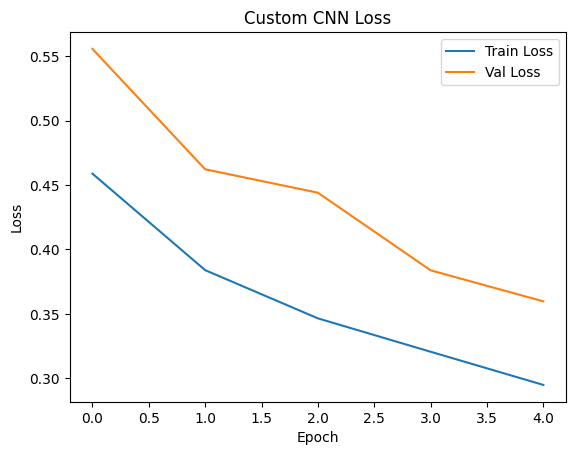

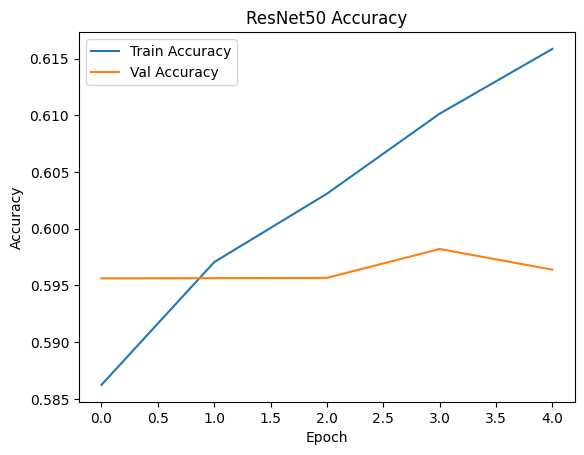

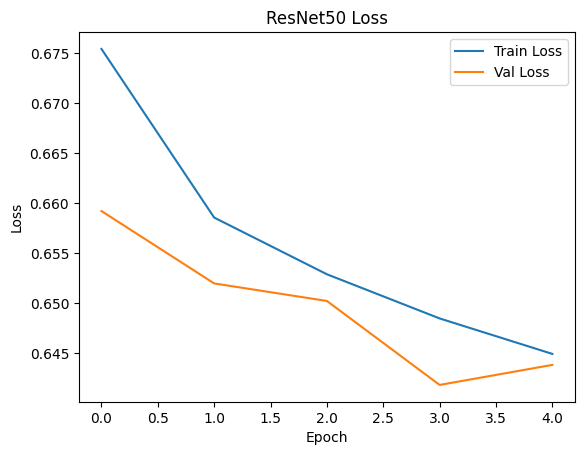

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step
Confusion Matrix (Custom CNN):
[[25113  1097]
 [ 5179 12616]]

Classification Report (Custom CNN):
              precision    recall  f1-score   support

           0     0.8290    0.9581    0.8889     26210
           1     0.9200    0.7090    0.8008     17795

    accuracy                         0.8574     44005
   macro avg     0.8745    0.8336    0.8449     44005
weighted avg     0.8658    0.8574    0.8533     44005

Found 57458 validated image filenames.


/Users/jeffreylind/anaconda3/envs/CSCA/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 293s 163ms/step
Submission saved to my_kaggle_submission.csv


In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_labels_df = pd.read_csv("data/train_labels.csv")
train_labels_df['filename'] = train_labels_df['id'].apply(lambda x: f"{x}.tif")

train_split = 0.8
split_index = int(len(train_labels_df) * train_split)

df_train = train_labels_df.iloc[:split_index].reset_index(drop=True)
df_val = train_labels_df.iloc[split_index:].reset_index(drop=True)

print(f"Training samples: {len(df_train)}, Validation samples: {len(df_val)}")

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory='data/train',
    x_col='filename',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='raw',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory='data/train',
    x_col='filename',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='raw',
    shuffle=False
)

history_custom = custom_cnn.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)

val_loss_custom, val_acc_custom = custom_cnn.evaluate(val_generator)
print(f"Custom CNN Validation Loss: {val_loss_custom:.4f}, Accuracy: {val_acc_custom:.4f}")

history_resnet = resnet50_transfer.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)

val_loss_resnet, val_acc_resnet = resnet50_transfer.evaluate(val_generator)
print(f"ResNet50 Validation Loss: {val_loss_resnet:.4f}, Accuracy: {val_acc_resnet:.4f}")

plt.figure()
plt.plot(history_custom.history['accuracy'], label='Train Accuracy')
plt.plot(history_custom.history['val_accuracy'], label='Val Accuracy')
plt.title('Custom CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(history_custom.history['loss'], label='Train Loss')
plt.plot(history_custom.history['val_loss'], label='Val Loss')
plt.title('Custom CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(history_resnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Val Accuracy')
plt.title('ResNet50 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(history_resnet.history['loss'], label='Train Loss')
plt.plot(history_resnet.history['val_loss'], label='Val Loss')
plt.title('ResNet50 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

import numpy as np

val_generator.reset()
pred_probs_custom = custom_cnn.predict(val_generator, verbose=1)
pred_custom = (pred_probs_custom.ravel() > 0.5).astype(int)

y_true_custom = df_val['label'].values
cm_custom = confusion_matrix(y_true_custom, pred_custom)
cr_custom = classification_report(y_true_custom, pred_custom, digits=4)

print("Confusion Matrix (Custom CNN):")
print(cm_custom)
print("\nClassification Report (Custom CNN):")
print(cr_custom)

submission_df = pd.read_csv("data/sample_submission.csv")

submission_df['filename'] = submission_df['id'].apply(lambda x: f"{x}.tif")

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=submission_df,
    directory="data/test",
    x_col="filename",
    y_col=None,
    target_size=(96, 96),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

test_preds = resnet50_transfer.predict(test_generator, verbose=1)
submission_df['label'] = (test_preds.ravel() > 0.5).astype(int)

submission_df.drop(columns='filename', inplace=True)
submission_df.to_csv("my_kaggle_submission.csv", index=False)
print("Submission saved to my_kaggle_submission.csv")

## Conclusion
Overall, the custom CNN outperformed the transfer learning approach in this task, achieving a validation accuracy of around 85.7% versus the transfer learning approach of 59.6% for the ResNet50-based model. 

1. Performance Drivers
    - The custom CNN achived better results with a relatively simple achitecture, with  a moderate depth combined with dropout and data augmentation.
    - Despite the ResNet50 model having a strong generalized backbone, it underperformed our custom CNN.
2. What Helped
    - Mild transformations improved the robustness of the custom CNN.
    - The dropout lyaer in the network helped reduce overfitting.
3. What did not help
    - The basic transfer learning was not valuable in comparison to the foundational custom CNN.
    - The class imbalance was was not beneficial to either models.